# 3 hidden dimensions

Pretty simple idea this one (at least to implement).

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
# seed = np.random.randint(1, 2**32 - 1)  # now starting to search through the seeds again
seed = 3560698129
set_all_seeds(seed)
print(seed)

3560698129


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, dim=32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(2, dim, use_act=use_act),
            LinearLayer(dim, 1, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

Going to sample $x_1$ (mass) and $x_2$ (acceleration) such that their product is uniformly distributed.

In [4]:
eps = 0.5

Y = torch.rand(10000)
X = torch.empty(10000, 2)
X[:, 0] = Y / (torch.rand(10000) * (1 - eps) + eps)
X[:, 1] = Y / X[:, 0]

# need to randomly swap x1 and x2 so that they're identically distributed - can do this because their product is commutative
mask = torch.rand(10000) < 0.5
swap_vals = X[:, 0][mask]
X[:, 0][mask] = X[:, 1][mask]
X[:, 1][mask] = swap_vals

assert torch.allclose(X[:, 0] * X[:, 1], Y)

Y = Y[:, None]
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

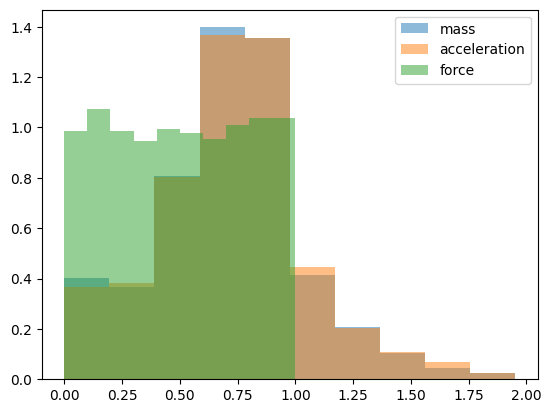

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

In [6]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Training

I'll just do full gradient descent to keep things simple.

In [7]:
N = 4000  # number of epochs

model = Net(use_act=True, dim=3)  # 3D here we go
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [8]:
def plot_loss(train_loss, valid_loss):
    _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs):
    _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()

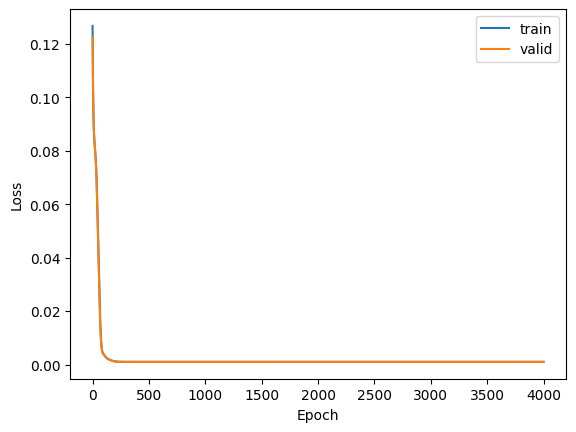

In [9]:
plot_loss(df["train_loss"], df["valid_loss"])

In [10]:
y_preds, y_targs = get_preds(model)

In [11]:
get_valid_loss(model, loss_func)

tensor(0.0010)

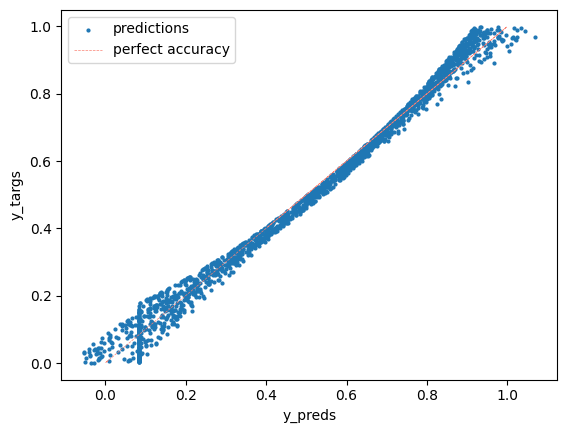

In [12]:
plot_results(y_preds, y_targs)

Ok this loss seems a little more optimal than what I could get with 2D and the predictions look kind of the same.

## Introspection

In [20]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=3, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=3, out_features=1, bias=True)
    )
  )
)

In [21]:
for name, param in model.named_parameters():
    print(name, "\n", param.data, "\n")

layers.0.linear.weight 
 tensor([[ 0.8839,  0.5813],
        [ 0.6009, -0.4508],
        [ 0.3097, -0.2156]]) 

layers.0.linear.bias 
 tensor([-0.6039, -0.1538, -0.5109]) 

layers.1.linear.weight 
 tensor([[ 1.0242, -0.6469,  0.3421]]) 

layers.1.linear.bias 
 tensor([0.0846]) 



### Inspect intermediate values

In [22]:
SD = model.state_dict()

In [23]:
from collections import OrderedDict
import torch
import torch.nn as nn


def capture_intermediate_outputs(model, input_tensor):
    """
    Captures the intermediate outputs of a PyTorch model.

    Args:
        model: A PyTorch model.
        input_tensor: A PyTorch tensor of shape (batch_size, *).
    Returns:
        A dictionary mapping layer names to intermediate outputs.
    """
    intermediate_values = OrderedDict()

    def hook_fn(module, input, output, name):
        if isinstance(module, nn.Linear):
            weight = module.weight
            input_value = input[0]
            intermediate_output = input_value.matmul(weight.t())
            intermediate_values[f"{name}.weight"] = intermediate_output
            intermediate_values[f"{name}.bias"] = output
        else:
            intermediate_values[name] = output

    hooks = []
    for name, layer in model.named_modules():
        hook = layer.register_forward_hook(
            lambda module, input, output, name=name: hook_fn(module, input, output, name)
        )
        hooks.append(hook)

    with torch.inference_mode():
        _ = model(input_tensor)

    for hook in hooks:
        hook.remove()

    filtered_values = {k: t for k, t in intermediate_values.items() if len(k.split(".")) > 2}
    return filtered_values


# a function that uses capture_intermediate_outputs to give a nice printed summary of the model outputs and parameters
def print_model_summary(model, input_tensor):
    intermediate_values = capture_intermediate_outputs(model, input_tensor)

    for k, v in intermediate_values.items():
        print(f"{k}: {v}")

In [24]:
print_model_summary(model, X_valid[0])

layers.0.linear.weight: tensor([ 0.9228, -0.1499, -0.0619])
layers.0.linear.bias: tensor([ 0.3189, -0.3037, -0.5728])
layers.0.act: tensor([0.3189, 0.0000, 0.0000])
layers.1.linear.weight: tensor([0.3267])
layers.1.linear.bias: tensor([0.4113])


In [78]:
from collections import OrderedDict


def plot_model_breakdown(
    x1, x2, dim1, dim2, point_selector, ax=None, legend=True, color=None, product_color=False, lines=True
):
    """
    Plots the breakdown of a model's output into its intermediate components.

    Args:
        x1: The first input value.
        x2: The second input value.
        point_selector: A dictionary mapping layer names to booleans. If a layer name is in the dictionary, then the corresponding point will be plotted.
        ax: A matplotlib axes object.
        legend: Whether to show the legend.
        color: The color of the points.
        product_color: Whether to color the points by the product of x1 and x2.
        lines: Whether to draw lines between the points.
    Returns:
        The matplotlib axes object.
    """
    if not ax:
        fig = plt.figure()
        ax = plt.axes()

    input = (x1, x2)

    if not color and product_color:
        val = x1 * x2
        cmap = cm.plasma
        val = val**0.5  # looks better on the unit square with some scaling
        color = cmap(val)

    x = capture_intermediate_outputs(model, torch.tensor([x1, x2]).float())
    dim = list(x.values())[1].shape[0]
    x = {k: t.tolist() for k, t in x.items()}
    x = {**{"input": list(input)}, **x}
    x = {
        k: (t + (dim - len(t)) * [0.0] if len(t) < dim else t) for k, t in x.items()
    }  # pad with 0s for input and near-output values

    markers = {k: "o" for k, _ in x.items()}
    markers["input"] = "v"
    markers[list(x.keys())[-1]] = "x"

    for point_name, point in x.items():
        if point_selector[point_name]:
            point = [point[dim1], point[dim2]]
            ax.scatter(*point, alpha=1.0, label=point_name, color=color, marker=markers[point_name])

    x_arr = np.array(list(x.values()))

    if lines:
        ax.plot(*x_arr.T, lw=0.5, color=color)
    ax.set(xlabel="component 0", ylabel="component 1")
    if legend:
        ax.legend()


def get_colors(N):
    cmap = plt.get_cmap("turbo", N)
    colors = []
    for i in range(cmap.N):
        colors.append(cmap(i))
    return colors


def get_default_point_selector_sets():
    subsets = []
    for i in range(6):
        subset = {
            "input": False,
            "layers.0.linear.weight": False,
            "layers.0.linear.bias": False,
            "layers.0.act": False,
            "layers.1.linear.weight": False,
            "layers.1.linear.bias": True,
        }
        subset[list(subset.keys())[i]] = True
        subsets.append(subset)
    subsets[0]["input"] = True
    return subsets


def plot_subsets(dim1, dim2, axes=None):
    """
    Plots the breakdown of a model's output into its intermediate outputs.

    Args:
        return_fig: Whether to return the figure and axes objects.
    Returns:
        The matplotlib figure and axes objects.
    """
    if axes is None:
        fig, axes = plt.subplots(5, 1, figsize=(10, 70))

    N = 5
    pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

    subsets = get_default_point_selector_sets()

    titles = list(subsets[0].keys())[:-1]

    for ax, subset, title in zip(axes.flatten(), subsets, titles):
        plot_model_breakdown(*pairs[0], dim1, dim2, ax=ax, product_color=True, point_selector=subset, lines=False)
        for pair in pairs[1:]:
            plot_model_breakdown(
                *pair, dim1, dim2, ax=ax, legend=False, product_color=True, point_selector=subset, lines=False
            )
        ax.vlines(0, -2, 2, color="gray", ls="--", lw=0.5)
        ax.hlines(0, -2, 2, color="gray", ls="--", lw=0.5)
        ax.set_title(title)
        ax.set_aspect("equal")

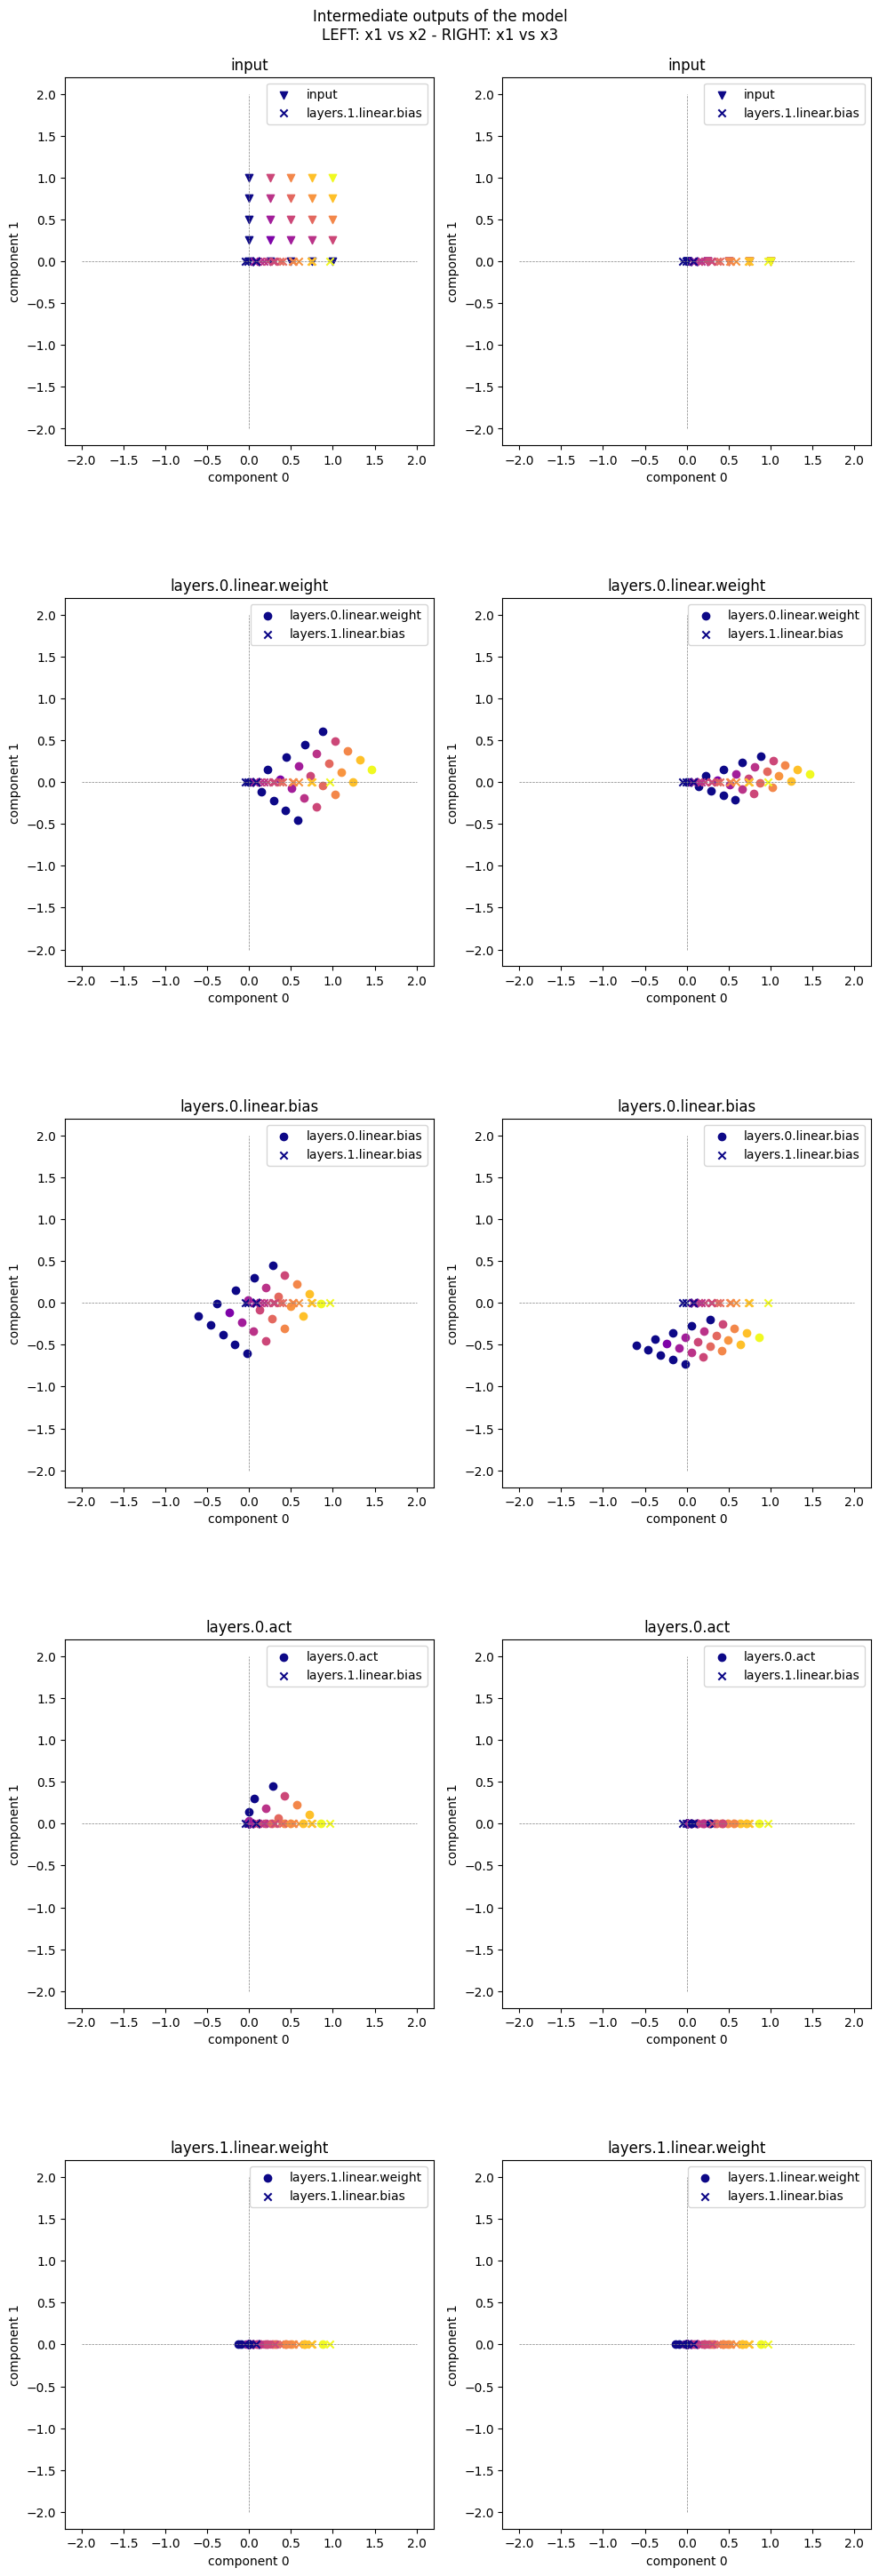

In [84]:
fig, axes = plt.subplots(5, 2, figsize=(10, 30))

plot_subsets(dim1=0, dim2=1, axes=axes[:, 0])
plot_subsets(dim1=0, dim2=2, axes=axes[:, 1])

fig.suptitle("Intermediate outputs of the model\nLEFT: x1 vs x2 - RIGHT: x1 vs x3")
fig.tight_layout()

I've changed the plot so that we can view both components at once side by side. Slight difficulties arise due to the fact that I've decided that my input sits on the unit square across the first two dimensions (and not the third) - but this is not so important once it's understood. I'm not quite ready to get into 3d plots just yet because they aren't exactly any more scalable to other dimensions so I don't really see the point.

## Analysis

There seem to be some extra modes going on here that I hadn't really considered in the 2D case (as I don't think I really observed them), but make sense now. I suppose you could describe the modes in terms of **which 2D quadrants** the unit square ends up overlapping after `layers.0.linear.bias`. Intuitively, there are these combinations:

In [96]:
from itertools import combinations
from pprint import pprint

# define the elements to permute
elements = ("TR", "BR", "BL", "TL")

# find all permutations of any length
all_combinations = []
for i in range(1, len(elements) + 1):
    all_combinations += list(combinations(elements, i))

for i, combination in enumerate(all_combinations):
    print(f"{i+1}: {combination}")

1: ('TR',)
2: ('BR',)
3: ('BL',)
4: ('TL',)
5: ('TR', 'BR')
6: ('TR', 'BL')
7: ('TR', 'TL')
8: ('BR', 'BL')
9: ('BR', 'TL')
10: ('BL', 'TL')
11: ('TR', 'BR', 'BL')
12: ('TR', 'BR', 'TL')
13: ('TR', 'BL', 'TL')
14: ('BR', 'BL', 'TL')
15: ('TR', 'BR', 'BL', 'TL')


Where I've defined the quadrants as so:

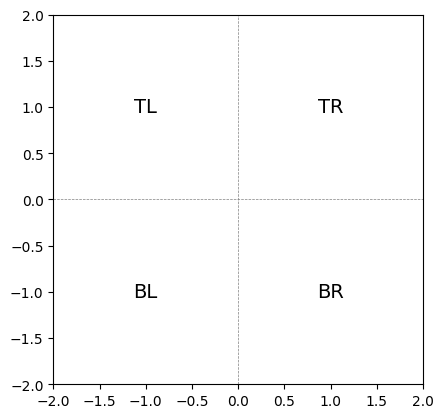

In [97]:
fig, ax = plt.subplots()

# set the x and y limits
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

ax.vlines(0, -2, 2, color="gray", ls="--", lw=0.5)
ax.hlines(0, -2, 2, color="gray", ls="--", lw=0.5)

# add the text in the center of each quadrant
ax.text(-1, 1, "TL", ha="center", va="center", fontsize=14)
ax.text(1, 1, "TR", ha="center", va="center", fontsize=14)
ax.text(-1, -1, "BL", ha="center", va="center", fontsize=14)
ax.text(1, -1, "BR", ha="center", va="center", fontsize=14)
ax.set_aspect("equal")

I think this represents a more complete picture than what I started with the different modes in `001-f-equals-ma`.

We can see that mode 1 is described by combination 3 (maybe $C_3$ from now on).

Mode 2 is typified by $C_2$ or $C_4$.

"Mode 2.5" is typified by $C_1$.

Mode 3 is typified by $C_5$ or $C_7$.

I'm not sure if it's relevant but I wonder if there's some relationship between performance increases and activating quadrants 🤔

### Extra modes

So now we can start thinking about the combinations that I hadn't considered/observed before.

I consider $C_6$ and $C_9$ to be of probably negligible significance in practice because unless the network settles upon a perfect weight matrix which transforms the points onto a perfect line that travels directly through the origin, these will most likely bleed into $C_{11}$-$C_{15}$.

I suppose I have not yet observed a transformed square spanning three 2D quadrants although it is intuitively possible. Perhaps I'll leave $C_{11}$-$C_{14}$ (inclusive) for now.

So all the interesting combinations to consider are (I think):
- $C_8$
- $C_{10}$
- $C_{15}$

### $$\begin{align*}C_{15}\end{align*}$$

This one felt most interesting to start with because it appears in this example.

Intuitively, this allows any points in the BL quadrant to be sent straight to 0 on both axes in question. Maybe this is a more valid approach in 3D because we have an extra dimension to play with where those values might not be all 0?

The only other difference we have after that is the _simultaneous_ ReLU projection of the BR and TL quadrant values to their respective axes - almost like a hybrid of the $C_5$ and $C_7$ approaches.

### $$C_{8}$$

This is again interesting to consider because it is observed in this case in the 3rd component.

Perhaps negating my idea from before about the BL quadrant being used since we have an extra dimension to play with, this also results in the ReLU projection of a large number of points to 0 on both dimensions in consideration (I suppose hence the line we see in the prediction scatter plot). This I reckon probably isn't quite optimal.

Otherwise this is acting much like a $C_2$ or $C_4$ in just ReLU projecting all the rest of the points to the remaining axis.

### $$C_{10}$$

Seems to me to be identical to $C_8$ but with the axes flipped.

**(Apologies for my anthropomorphisation of this collection of linear algebra 🤖)**

I have a hunch that a $C_5$/$C_7$ approach on extra dimensions is going to be optimal but let's see what more training runs reveal (in a new notebook).

In [98]:
# torch.save(model.state_dict(), 'models/e-1-3560698129.pth')